# MC920 - Processamento de sinais

# Trabalho 2 - Filtragem no domínio de frequências

Nome: Guilherme de Oliveira Zaleski | RA: 235914

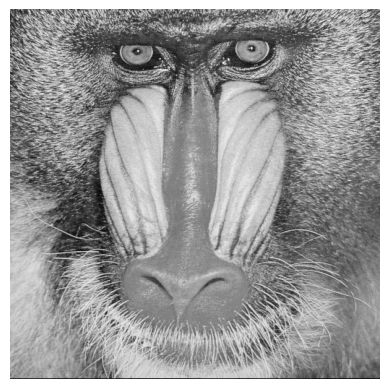

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

img = cv2.imread('baboon.png', cv2.IMREAD_GRAYSCALE)

def display_img(img):
  # Display the result
  plt.imshow(img, cmap="gray")
  plt.axis("off")
  plt.show()

display_img(img)

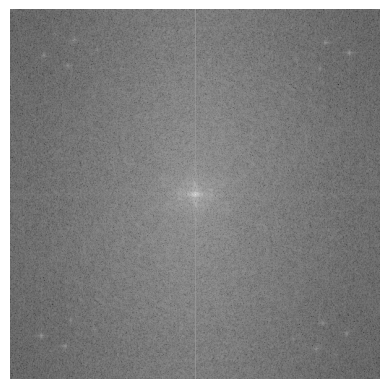

In [98]:
import numpy as np
import matplotlib.pyplot as plt

def apply_fft(img):
  # Apply FFT
  fft_img = np.fft.fft2(img)

  # Shift zero frequency component to the center
  centered_img = np.fft.fftshift(fft_img)

  # Returns the transformed image with zero frequency shifted to the center
  return centered_img

def fft_magnitude(centered_img):
  # Take absolute value and apply logarithmic scale
  fft_magnitude = np.log10(np.abs(centered_img))

  return fft_magnitude

fft_img = apply_fft(img)
fft_magn = fft_magnitude(fft_img)
display_img(fft_magn)

##Passa-baixa

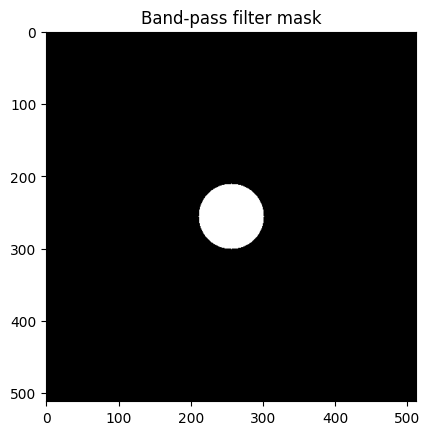

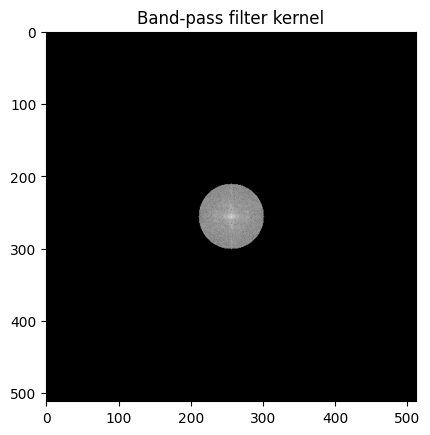

In [99]:
import numpy as np

def kernel_gen(img, freq_min = 0, freq_max = 0, filter_type = 'None'):
  filter_dict = {"lp": "Low-pass", "hp": "High-pass", "bp": "Band-pass", "bs": "Band-stop"}

  if(filter_type == 'None'):
    raise ValueError("The image was not filtered. Filter type not defined.")
  if(filter_type not in filter_dict):
    raise ValueError("The image was not filtered. Filter type does not exist.")

  filter_name = filter_dict[filter_type]

  fft_img = apply_fft(img)
  fft_magn = fft_magnitude(fft_img)

  height, width = fft_img.shape
  # Calculate the filter mask
  mask = np.zeros((height, width))
  for i in range(height):
      for j in range(width):
          distance_from_center = np.sqrt((i - height // 2)**2 + (j - width // 2)**2)
          match filter_type:
            case "lp":
              if distance_from_center <= freq_max:
                mask[i,j] = 1
              else:
                mask[i,j] = 0
            case "hp":
              if distance_from_center <= freq_max:
                mask[i,j] = 0
              else:
                mask[i,j] = 1
            case "bp":
              if distance_from_center >= freq_min and distance_from_center <= freq_max:
                mask[i, j] = 1
              else:
                mask[i, j] = 0
            case "bs":
              if distance_from_center >= freq_min and distance_from_center <= freq_max:
                mask[i, j] = 0
              else:
                mask[i, j] = 1


  plt.imshow(mask, cmap = 'gray')
  plt.title(f"{filter_name} filter mask")
  plt.show()

  kernel = np.zeros((height,width))

  kernel[:,:] = mask[:,:] * fft_magn

  kernel[:,:] = np.where(kernel == 0, np.min(fft_magn)-(1e-10),kernel[:,:])

  plt.imshow(kernel,cmap = 'gray',vmin = np.min(fft_magn), vmax = np.max(fft_magn))
  plt.title(f"{filter_name} filter kernel")
  plt.show()
  fft_img[:,:].real = np.where(kernel != np.min(fft_magn)-(1e-10) , fft_img[:,:].real, 0)
  fft_img[:,:].imag = np.where(kernel != np.min(fft_magn)-(1e-10)  , fft_img[:,:].imag, 0)
  return fft_img

fft_img = kernel_gen(img, freq_min = 0, freq_max = 45,filter_type = "bp")

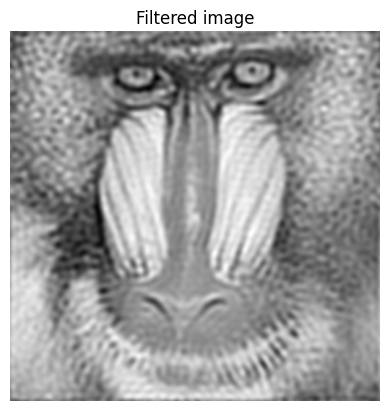

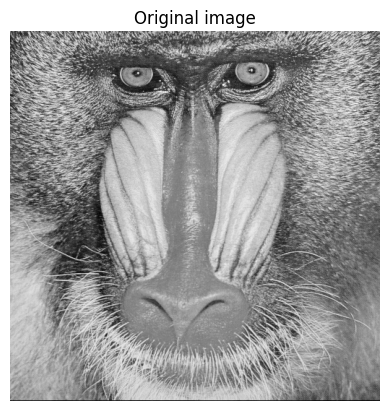

In [100]:
def apply_ifft(fft_img):
  # Undo the centering
  uncentered_fft_image = np.fft.ifftshift(fft_img)
  # Apply IFFT to reconstruct the image
  reconstructed_img = abs((np.real(np.fft.ifft2(uncentered_fft_image))))
  return reconstructed_img

def compare_imgs(alt_img, orig_img, is_filter = 1, file = "output"):
  # Display the altered image
  plt.imshow(alt_img, cmap = "gray")  # plots the image in gray scale
  plt.axis("off")                     # turn off the axes
  plt.savefig(f"{file}.png")           # exports the png output
  if is_filter:                       # sets the altered image title
    plt.title("Filtered image")
  else:
    plt.title("Compressed image")
  plt.show()                          # displays the image on the screen
  # Display the original image
  plt.imshow(orig_img, cmap = "gray")
  plt.axis("off")
  plt.title("Original image")
  plt.show()
reconstructed_img = apply_ifft(fft_img)
compare_imgs(reconstructed_img, img, "low_pass_out")

#Passa-alta

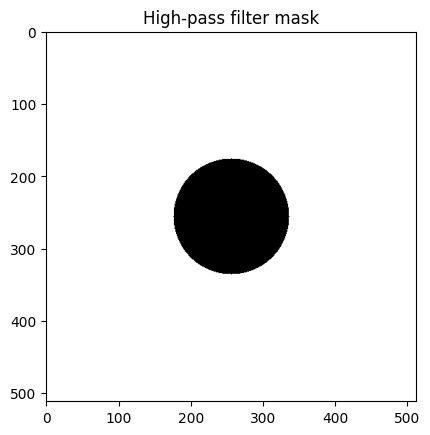

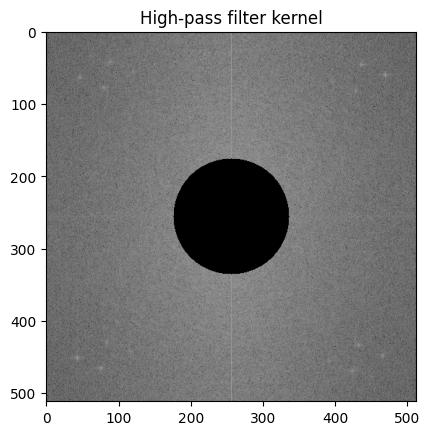

In [101]:
fft_img = kernel_gen(img, freq_min = 0, freq_max = 80,filter_type = "hp")

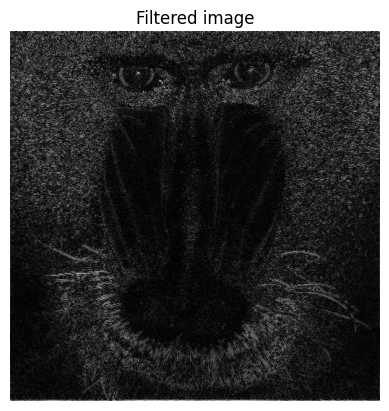

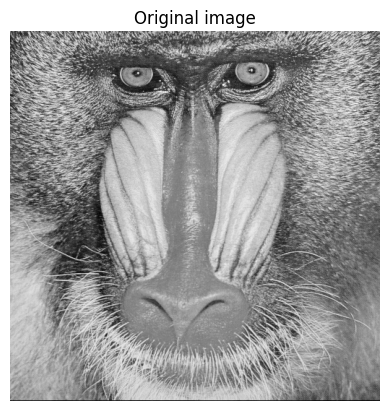

In [102]:
reconstructed_img = apply_ifft(fft_img)
compare_imgs(reconstructed_img, img, "high_pass_out")

##Passa-faixa


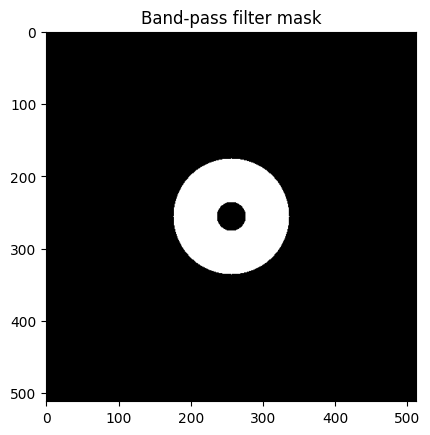

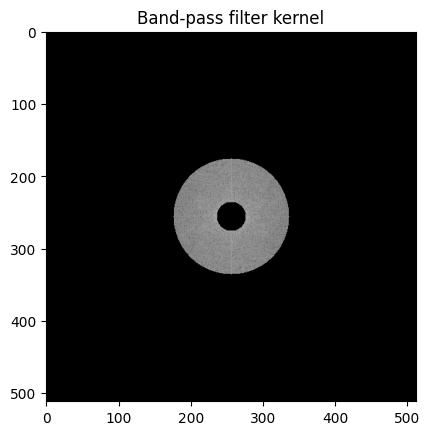

In [103]:
fft_img = kernel_gen(img, freq_min = 20, freq_max = 80,filter_type = "bp")

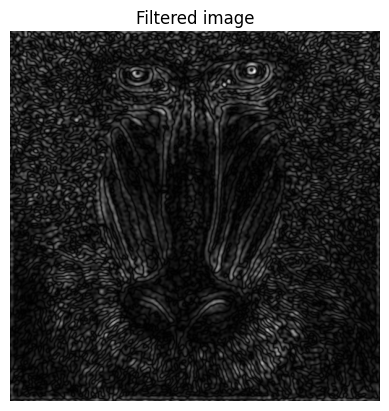

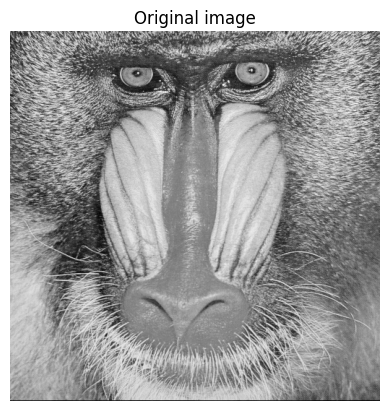

In [104]:
reconstructed_img = apply_ifft(fft_img)
compare_imgs(reconstructed_img, img, "band_pass_out")

##Rejeita-faixa

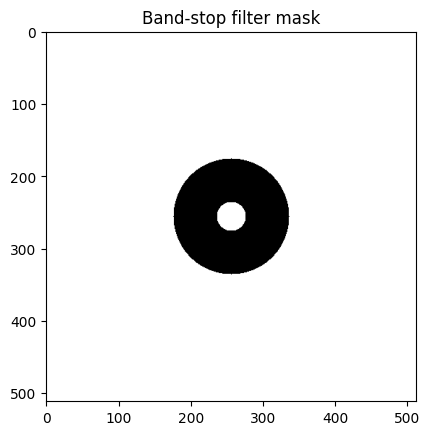

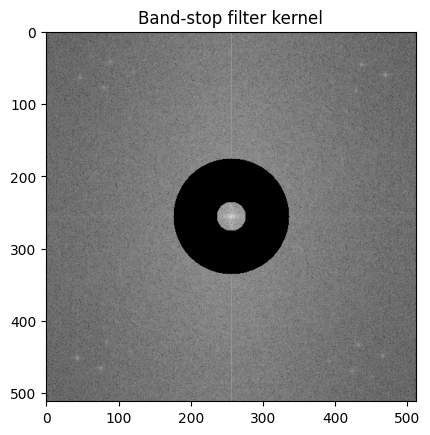

In [105]:
fft_img = kernel_gen(img, freq_min = 20, freq_max = 80,filter_type = "bs")

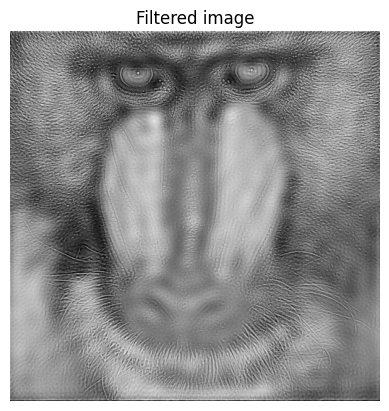

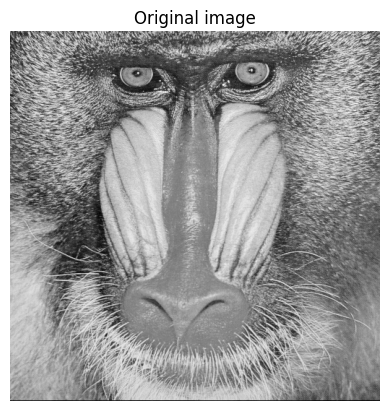

In [106]:
reconstructed_img = apply_ifft(fft_img)
compare_imgs(reconstructed_img, img, "band_stop_out")

#Compressão

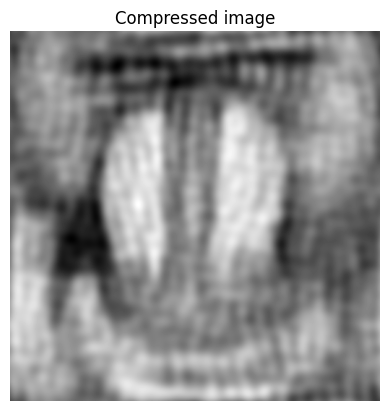

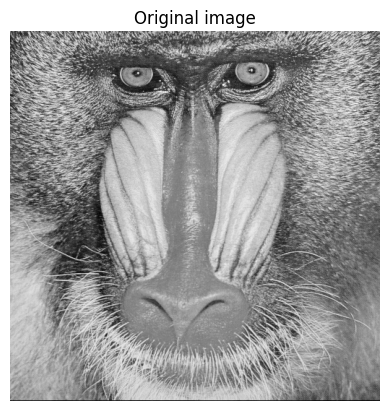

In [107]:
def compress_img(img, compress_ratio = 0.65):
  fft_img = apply_fft(img)
  fft_magn = fft_magnitude(fft_img)
  threshold = (compress_ratio * (np.max(fft_magn)-np.min(fft_magn))) + np.min(fft_magn)
  fft_img[:,:].real = np.where(fft_magn[:,:].real > threshold, fft_img[:,:].real, 0)
  fft_img[:,:].imag = np.where(fft_magn[:,:].real > threshold, fft_img[:,:].imag, 0)
  return fft_img
compressed_img = apply_ifft(compress_img(img))
compare_imgs(compressed_img, img, is_filter = 0)

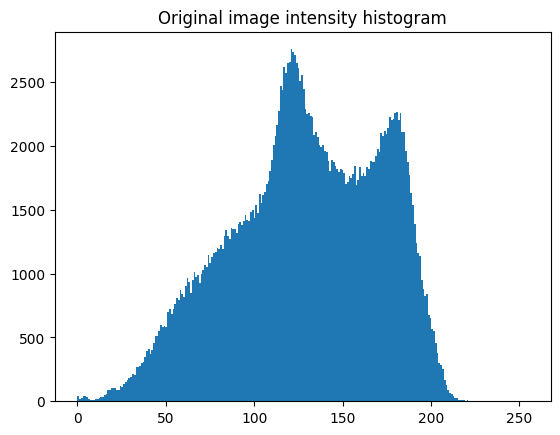

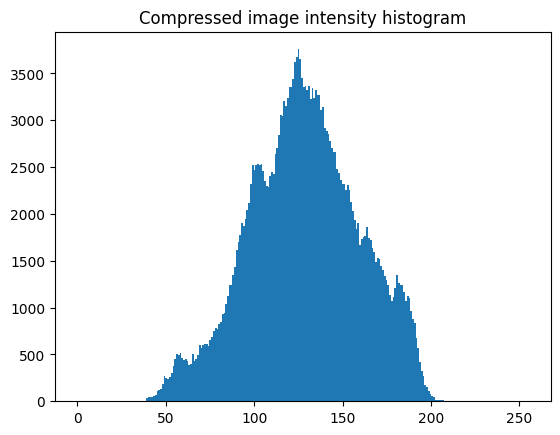

In [108]:
import cv2
import matplotlib.pyplot as plt

def comp_intes_hists(compressed_img, original_img):
  # Calculate the histograms
  hist = cv2.calcHist(original_img, [0], None, [256], [0, 255])
  compressed_hist = cv2.calcHist(compressed_img, [0], None, [256], [0, 255])

  # Plot the histograms
  plt.hist(original_img.ravel(), 256, [0, 255])
  plt.title("Original image intensity histogram")
  plt.show()
  plt.hist(compressed_img.ravel(), 256, [0, 255])
  plt.title("Compressed image intensity histogram")
  plt.show()

# Convert the compressed matrix into an int matrix
compressed = compressed_img.astype(np.uint8)

# Plot histograms
comp_intes_hists(compressed,img)

